<a href="https://colab.research.google.com/github/ahsplore/BigDataAnalytics/blob/main/miniproject%20-%20fraud%20detection%20in%20financial%20transactions/fraud_transaction_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Big Data Analysis - MiniProject

#***Fraud Detection Analysis in Creditcard Transaction using PySpark***

##**Project Overview :**
Detect fraudulent credit card transactions using **PySpark** for big data processing and machine learning. Handle class imbalance and build scalable fraud detection models.

## **Objectives**
- Exploratory Data Analysis (EDA) on transaction data
- Handle class imbalance (only 0.17% fraud)
- Build and compare ML models
- Identify key fraud patterns

## Dataset
- **Source**: https://www.kaggle.com/datasets/darshandalvi12/fraud-detection-in-financial-transactions?select=creditcard.csv
- **Size**: 260674 transactions, 31 features
- **Features**: Time, Amount, V1-V28 (PCA components), Class
- **Target**: Class (1=Fraud, 0=Legitimate)
- **Challenge**: Highly imbalanced (492 fraud cases)

## Technical Stack
- **PySpark** - Data processing & ML
- **Python** - Visualization & analysis
- **MLlib** - Machine learning
- **Matplotlib/Seaborn** - Plots

## Methodology

### 1. Data Preprocessing
- Handle class imbalance (undersampling)
- Feature scaling
- Train-test split (80-20)

### 2. Machine Learning Models
- Logistic Regression
- Random Forest Classifier

### 3. Evaluation Metrics
- AUC-ROC
- Precision, Recall, F1-Score
- Confusion Matrix

## Visualizations
1. Class distribution pie chart
2. Transaction amount analysis
3. Time vs Amount patterns
4. Feature correlations
5. Model performance comparison
6. Feature importance

## Implementation Steps
1. Load and explore data
2. Preprocess and balance data
3. Train ML models
4. Evaluate performance
5. Visualize results
6. Generate insights

## Expected Outcomes
- High-accuracy fraud detection model
- Key feature identification
- Scalable PySpark pipeline
- Business insights for fraud prevention

---

**Business Impact**: Reduce financial losses through automated fraud detection system.

Install Required Packages

In [ ]:
# Install Python packages
!pip install pyspark matplotlib seaborn pandas numpy jupyter findspark

Import Libraries

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Setup and Data Loading

In [ ]:
spark = SparkSession.builder.appName("FraudDetection").getOrCreate()

In [ ]:
# Load data
df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/miniproject - fraud detection in financial transactions/dataset/creditcard.csv", header=True, inferSchema=True)

print("Dataset Info:")
print(f"Records: {df.count()}, Features: {len(df.columns)}")
df.show(5)

Dataset Info:
Records: 260674, Features: 31
+----+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------+-----+
|Time|          V1|          V2|         V3|          V4|          V5|          V6|          V7|          V8|          V9|         V10|         V11|         V12|         V13|         V14|         V15|         V16|         V17|         V18|         V19|         V20|         V21|         V22|         V23|         V24|         V25|         V26|         V27|         V28|Amount|Class|
+----+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+---

Exploratory Data Analysis & Visualizations

/tmp/ipython-input-2774271349.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,1].boxplot([pdf[pdf['Class']==0]['Amount'], pdf[pdf['Class']==1]['Amount']],


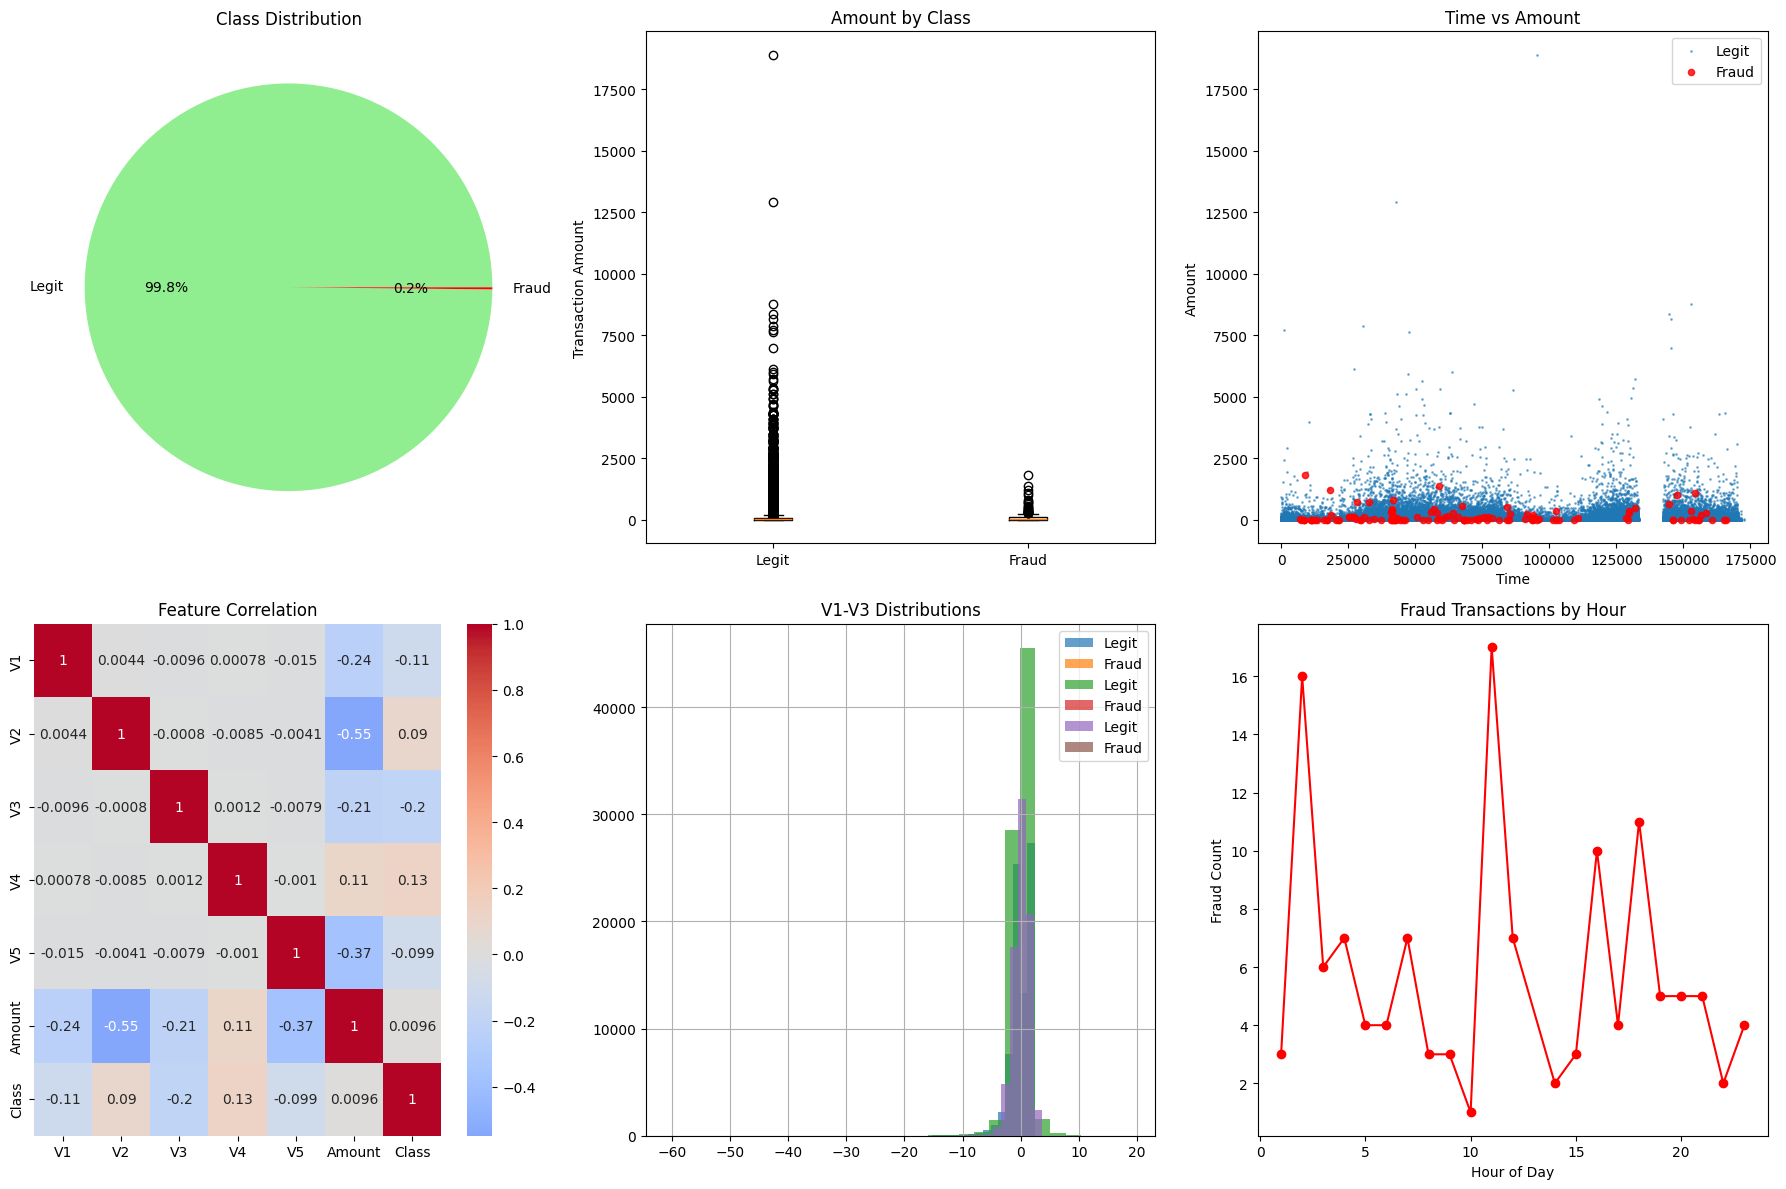

In [ ]:
pdf = df.sample(False, 0.3).toPandas()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Class Distribution
class_counts = pdf['Class'].value_counts()
axes[0,0].pie(class_counts.values, labels=['Legit', 'Fraud'], autopct='%1.1f%%',
              colors=['lightgreen', 'red'])
axes[0,0].set_title('Class Distribution')


# 2. Amount Distribution
axes[0,1].boxplot([pdf[pdf['Class']==0]['Amount'], pdf[pdf['Class']==1]['Amount']],
                 labels=['Legit', 'Fraud'])
axes[0,1].set_ylabel('Transaction Amount')
axes[0,1].set_title('Amount by Class')

# 3. Time vs Amount
axes[0,2].scatter(pdf[pdf['Class']==0]['Time'], pdf[pdf['Class']==0]['Amount'],
                 alpha=0.5, label='Legit', s=1)
axes[0,2].scatter(pdf[pdf['Class']==1]['Time'], pdf[pdf['Class']==1]['Amount'],
                 alpha=0.8, label='Fraud', color='red', s=20)
axes[0,2].set_xlabel('Time')
axes[0,2].set_ylabel('Amount')
axes[0,2].legend()
axes[0,2].set_title('Time vs Amount')

# 4. Feature Correlation
corr_matrix = pdf[['V1','V2','V3','V4','V5','Amount','Class']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,0])
axes[1,0].set_title('Feature Correlation')

# 5. Feature Distributions
for i, feature in enumerate(['V1', 'V2', 'V3']):
    pdf[pdf['Class']==0][feature].hist(alpha=0.7, label='Legit', ax=axes[1,1], bins=30)
    pdf[pdf['Class']==1][feature].hist(alpha=0.7, label='Fraud', ax=axes[1,1], bins=30)
axes[1,1].legend()
axes[1,1].set_title('V1-V3 Distributions')

# 6. Fraud by Time Bins
pdf['hour'] = (pdf['Time'] / 3600).astype(int) % 24
fraud_by_hour = pdf[pdf['Class']==1].groupby('hour').size()
axes[1,2].plot(fraud_by_hour.index, fraud_by_hour.values, marker='o', color='red')
axes[1,2].set_xlabel('Hour of Day')
axes[1,2].set_ylabel('Fraud Count')
axes[1,2].set_title('Fraud Transactions by Hour')

plt.tight_layout()
plt.show()

Data Preprocessing with PySpark

In [ ]:
# data quality
print("Missing values:")
for column_name in df.columns:
    null_count = df.filter(df[column_name].isNull()).count()
    if null_count > 0:
        print(f"{column_name}: {null_count}")

# Class distribution
from pyspark.sql.functions import col
class_dist = df.groupBy("Class").count().withColumn("percentage",
                 col("count")/df.count() * 100)
class_dist.show()

# Handle class imbalance
fraud_count = df.filter(col("Class") == 1).count()
non_fraud_sample = df.filter(col("Class") == 0).sample(False, fraud_count*3/df.count())
balanced_df = non_fraud_sample.union(df.filter(col("Class") == 1))

print(f"Balanced dataset - Legit: {non_fraud_sample.count()}, Fraud: {fraud_count}")

Missing values:
+-----+------+-------------------+
|Class| count|         percentage|
+-----+------+-------------------+
|    1|   468|0.17953459109846015|
|    0|260206|  99.82046540890154|
+-----+------+-------------------+

Balanced dataset - Legit: 1494, Fraud: 468


Feature Engineering

In [ ]:
feature_columns = [f'V{i}' for i in range(1, 29)]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [ ]:
train_data, test_data = balanced_df.randomSplit([0.8, 0.2], seed=42)

Model Training

In [ ]:
# models (logistic, randomforest)
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="Class",
                       maxIter=10, regParam=0.01)
rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="Class",
                          numTrees=50, maxDepth=10, seed=42)

lr_pipeline = Pipeline(stages=[assembler, scaler, lr])
rf_pipeline = Pipeline(stages=[assembler, scaler, rf])

# Train models
print("Training models...")
lr_model = lr_pipeline.fit(train_data)
rf_model = rf_pipeline.fit(train_data)

Training models...


Model Evaluation

In [ ]:
# predictions
lr_pred = lr_model.transform(test_data)
rf_pred = rf_model.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="Class")

lr_auc = evaluator.evaluate(lr_pred)
rf_auc = evaluator.evaluate(rf_pred)

print(f"Logistic Regression AUC: {lr_auc:.4f}")
print(f"Random Forest AUC: {rf_auc:.4f}")

# metrics
def calculate_metrics(predictions, model_name):
    tp = predictions.filter((col("Class") == 1) & (col("prediction") == 1)).count()
    fp = predictions.filter((col("Class") == 0) & (col("prediction") == 1)).count()
    tn = predictions.filter((col("Class") == 0) & (col("prediction") == 0)).count()
    fn = predictions.filter((col("Class") == 1) & (col("prediction") == 0)).count()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{model_name} Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Confusion Matrix: TP={tp}, FP={fp}, TN={tn}, FN={fn}")

    return precision, recall, f1

lr_precision, lr_recall, lr_f1 = calculate_metrics(lr_pred, "Logistic Regression")
rf_precision, rf_recall, rf_f1 = calculate_metrics(rf_pred, "Random Forest")

Logistic Regression AUC: 0.9896
Random Forest AUC: 0.9905

Logistic Regression Metrics:
Precision: 0.9773
Recall: 0.8776
F1-Score: 0.9247
Confusion Matrix: TP=86, FP=2, TN=273, FN=12

Random Forest Metrics:
Precision: 0.9780
Recall: 0.9082
F1-Score: 0.9418
Confusion Matrix: TP=89, FP=2, TN=273, FN=9


Feature Importance & Results Visualization


Top 10 Most Important Features:
V14: 0.2151
V10: 0.1285
V11: 0.1185
V12: 0.1048
V17: 0.0977
V4: 0.0702
V16: 0.0431
V7: 0.0321
V3: 0.0268
V2: 0.0204


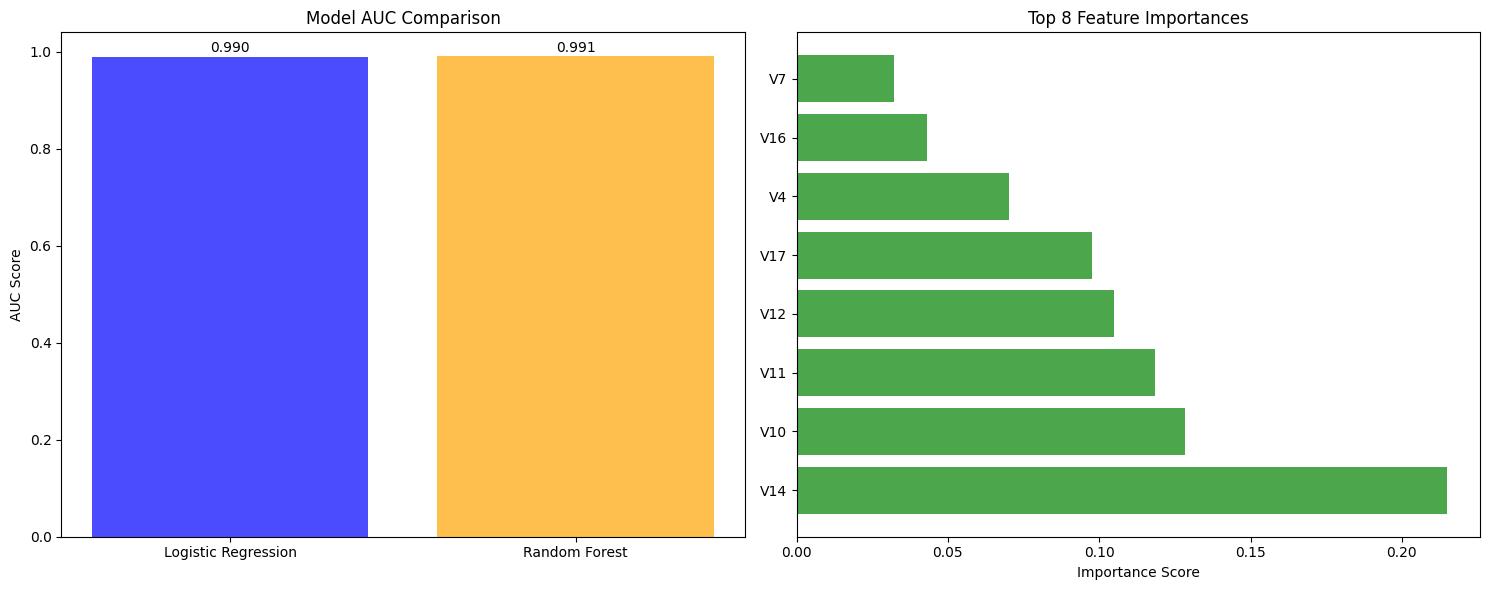

In [ ]:
rf_model_trained = rf_model.stages[-1]
feature_importance = list(zip(feature_columns, rf_model_trained.featureImportances.toArray()))
feature_importance.sort(key=lambda x: x[1], reverse=True)

print("\nTop 10 Most Important Features:")
for feature, importance in feature_importance[:10]:
    print(f"{feature}: {importance:.4f}")

# Results visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Model comparison
models = ['Logistic Regression', 'Random Forest']
auc_scores = [lr_auc, rf_auc]
f1_scores = [lr_f1, rf_f1]

x = range(len(models))
axes[0].bar(x, auc_scores, color=['blue', 'orange'], alpha=0.7)
axes[0].set_title('Model AUC Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].set_ylabel('AUC Score')

for i, v in enumerate(auc_scores):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Feature importance
top_features = feature_importance[:8]
features, importance = zip(*top_features)
axes[1].barh(range(len(features)), importance, color='green', alpha=0.7)
axes[1].set_yticks(range(len(features)))
axes[1].set_yticklabels(features)
axes[1].set_xlabel('Importance Score')
axes[1].set_title('Top 8 Feature Importances')

plt.tight_layout()
plt.show()

Final Summary

In [ ]:
print("\n" + "="*50)
print("FRAUD DETECTION PROJECT SUMMARY")
print("="*50)
print(f"Dataset: {df.count():,} transactions, {fraud_count:,} fraudulent ({fraud_count/df.count()*100:.2f}%)")
print(f"Best Model: Random Forest (AUC: {rf_auc:.4f}, F1: {rf_f1:.4f})")
print(f"Key Features: {', '.join([f[0] for f in feature_importance[:3]])}")
print("Business Impact: Can detect fraudulent transactions with high accuracy")
print("="*50)

spark.stop()


FRAUD DETECTION PROJECT SUMMARY
Dataset: 260,674 transactions, 468 fraudulent (0.18%)
Best Model: Random Forest (AUC: 0.9905, F1: 0.9418)
Key Features: V14, V10, V11
Business Impact: Can detect fraudulent transactions with high accuracy
